### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb



In [3]:
df_lagged = pd.read_csv(r'E:\Nieuw dataset\Timeseriessplit\evsales_trends_lagged_sales2_google0.csv')

### Time series split

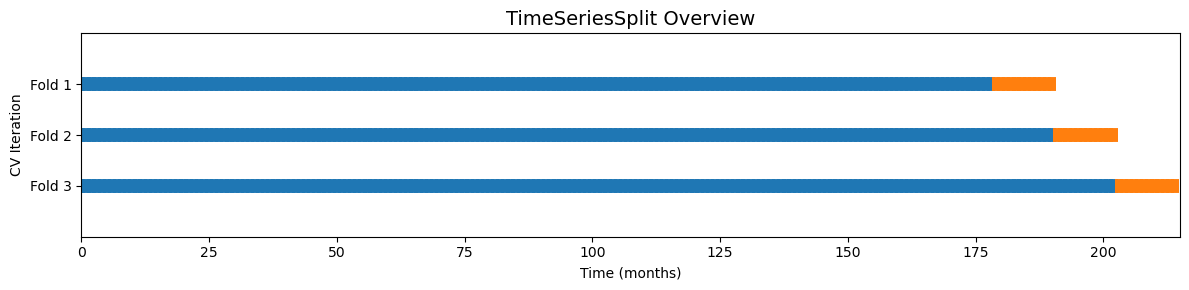

In [5]:
# --- Load your data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)
X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- Define TimeSeriesSplit ---
n_splits = 3
test_size = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# --- Custom color map for CV ---
cmap_cv = mcolors.ListedColormap(["#1f77b4", "#ff7f0e"])  # Blue for train, Orange for test

# --- Plot function ---
def plot_cv_indices(cv, X, y, ax, lw=10):
    for ii, (train_index, test_index) in enumerate(cv.split(X=X)):
        indices = np.full(len(X), np.nan)
        indices[train_index] = 0
        indices[test_index] = 1

        ax.scatter(
            range(len(X)),
            [ii + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=[f"Fold {i+1}" for i in range(n_splits)],
        xlabel="Time (months)",
        ylabel="CV Iteration",
        ylim=[n_splits + 0.5, -0.5],
        xlim=[0, len(X)],
    )
    ax.set_title("TimeSeriesSplit Overview", fontsize=14)

# --- Run and plot ---
fig, ax = plt.subplots(figsize=(12, 3))
plot_cv_indices(tscv, X, y, ax)
plt.tight_layout()
plt.show()


### Model 1 (Arima) 

ARIMA is a widely used model for time series analysis. It is a statistical model that uses past values to predict future values of a time series. ARIMA models are widely used in fields like finance, economics, and meteorology. The model works well when the data has a clear trend, seasonality, and is stationary.

https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3 


Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-04-01
RMSE: 2984.93
MAE: 2340.65
MAPE / Error margin (%): 17.27


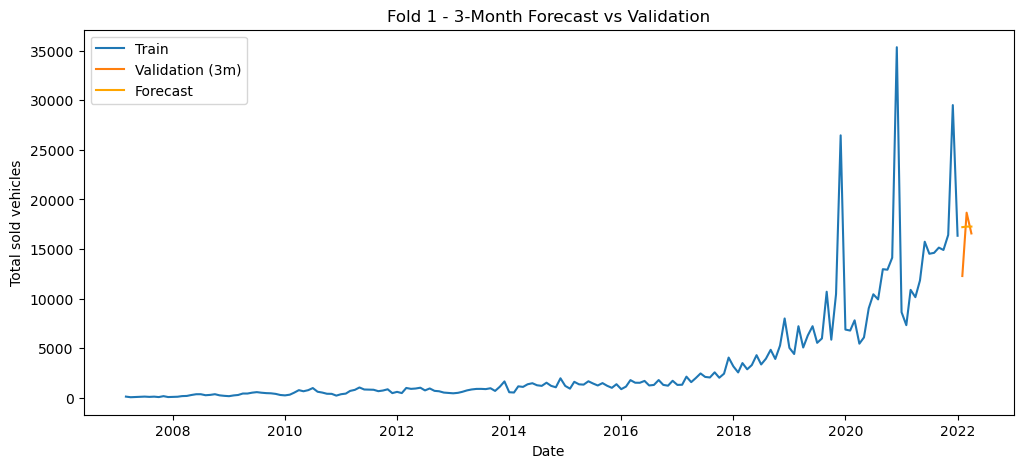


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-04-01
RMSE: 4162.09
MAE: 2917.66
MAPE / Error margin (%): 12.85


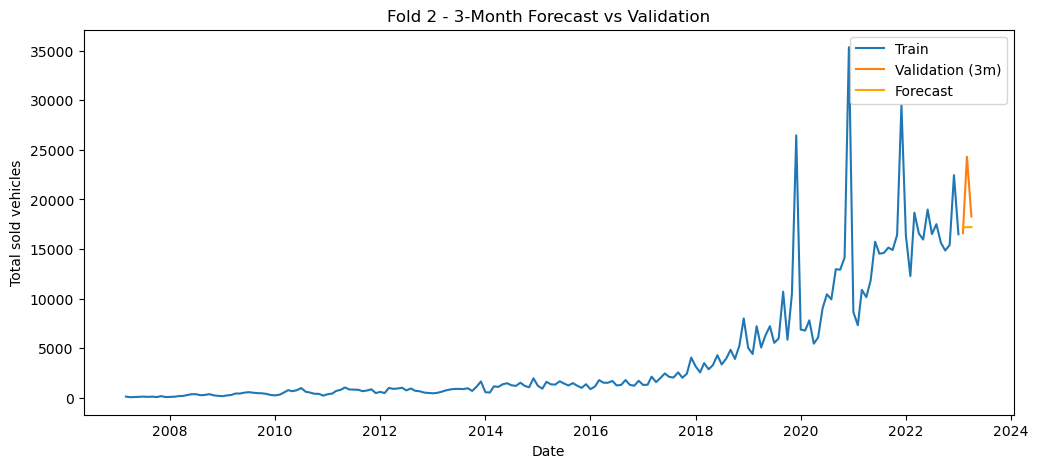


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-04-01
RMSE: 3468.77
MAE: 2946.26
MAPE / Error margin (%): 10.99


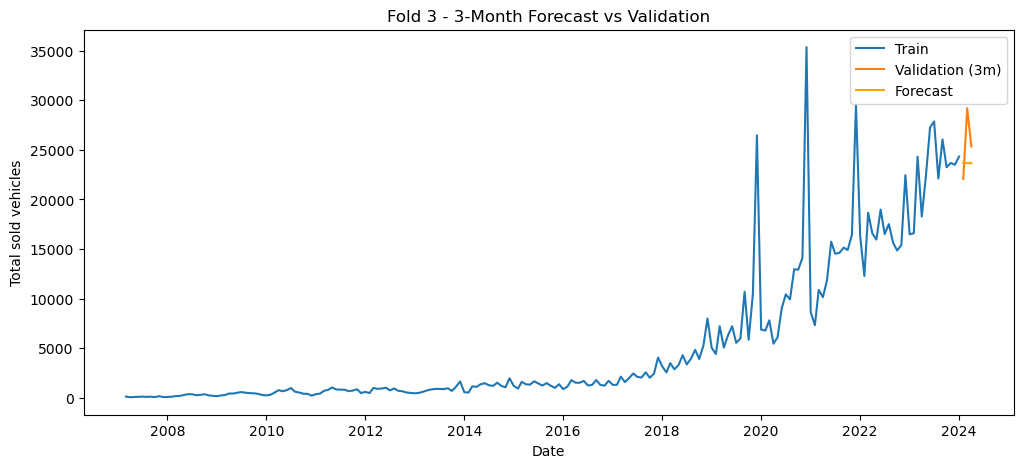


 Average performance over all folds:
Average RMSE: 3538.60
Average MAE: 2734.86
Average MAPE / Error margin (%): 13.70


In [6]:
# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Target only
y = df['Totaal_verkochte_wegvoertuigen']
forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores = [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100  # In percentage

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {(df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1)).date()}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

# Print averages
print("\n Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")


Arima doesnt use feature importance so sarima was used 


 Evaluating WITHOUT feature: thuis opladen

 Evaluating WITHOUT feature: elektrische auto

 Evaluating WITHOUT feature: hybride elektrisch

 Evaluating WITHOUT feature: Bijtellingspercentage


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\s


 Evaluating WITHOUT feature: Consumentenvertrouwen


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Evaluating WITHOUT feature: Economisch klimaat

 Evaluating WITHOUT feature: Koopbereidheid

 Evaluating WITHOUT feature: Grote aankopen

 Evaluating WITHOUT feature: BenzineEuro95_1_first

 Evaluating WITHOUT feature: BenzineEuro95_1_last

 Evaluating WITHOUT feature: BenzineEuro95_1_min

 Evaluating WITHOUT feature: BenzineEuro95_1_max

 Evaluating WITHOUT feature: BenzineEuro95_1_mean

 Evaluating WITHOUT feature: Diesel_2_first

 Evaluating WITHOUT feature: Diesel_2_last

 Evaluating WITHOUT feature: Diesel_2_min

 Evaluating WITHOUT feature: Diesel_2_max

 Evaluating WITHOUT feature: Diesel_2_mean

 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag1

 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag2


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 LOFO results (sorted by lowest RMSE):
                       Feature_left_out     Avg_RMSE      Avg_MAE  \
6                        Koopbereidheid  2212.410098  1782.601994   
18  Totaal_verkochte_wegvoertuigen_lag1  2422.869411  1860.193445   
19  Totaal_verkochte_wegvoertuigen_lag2  2620.498882  1922.657036   
1                      elektrische auto  2709.613392  2398.223795   
14                        Diesel_2_last  2887.673349  2369.606404   
15                         Diesel_2_min  2895.408285  2428.803252   
2                    hybride elektrisch  2898.826036  2361.000213   
11                  BenzineEuro95_1_max  2903.630158  2364.394288   
16                         Diesel_2_max  2905.810095  2377.342522   
13                       Diesel_2_first  2914.720548  2453.577635   
17                        Diesel_2_mean  2952.907018  2456.043105   
0                         thuis opladen  2989.429932  2489.145604   
7                        Grote aankopen  3028.756825  2490.7125

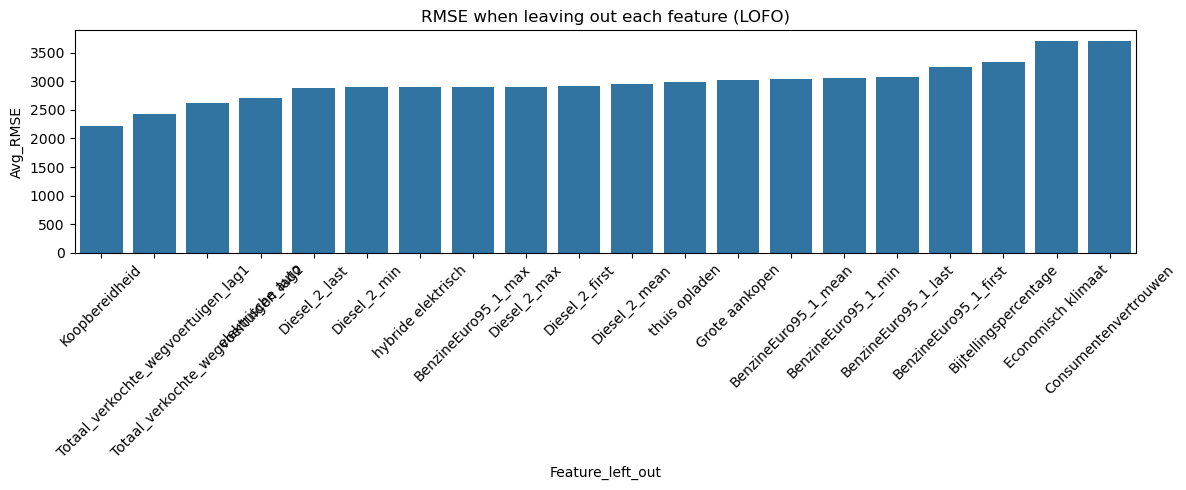

In [ ]:
# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

target_column = 'Totaal_verkochte_wegvoertuigen'
all_feature_columns = [col for col in df.columns if col not in ['Periode', target_column]]

forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

results = []

for feature_to_leave_out in all_feature_columns:
    print(f"\n Evaluating WITHOUT feature: {feature_to_leave_out}")
    feature_columns = [col for col in all_feature_columns if col != feature_to_leave_out]

    X = df[feature_columns]
    y = df[target_column]

    rmse_scores, mae_scores, mape_scores = [], [], []

    for i, (train_index, val_index) in enumerate(tscv.split(y)):
        y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
        X_train, X_val_full = X.iloc[train_index], X.iloc[val_index]

        y_val = y_val_full.iloc[:forecast_horizon]
        X_val = X_val_full.iloc[:forecast_horizon]

        # Fit SARIMAX
        model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

        rmse = np.sqrt(mean_squared_error(y_val, forecast))
        mae = mean_absolute_error(y_val, forecast)
        mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Store average results for this feature exclusion
    results.append({
        'Feature_left_out': feature_to_leave_out,
        'Avg_RMSE': np.mean(rmse_scores),
        'Avg_MAE': np.mean(mae_scores),
        'Avg_MAPE (%)': np.mean(mape_scores)
    })

# Show all results in a DataFrame
results_df = pd.DataFrame(results).sort_values('Avg_RMSE')
import seaborn as sns

print("\n LOFO results (sorted by lowest RMSE):")
print(results_df)

# Optional: Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x='Feature_left_out', y='Avg_RMSE')
plt.xticks(rotation=45)
plt.title('RMSE when leaving out each feature (LOFO)')
plt.tight_layout()
plt.show()


#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)